In [ ]:
!rm -rf /gpfs/global_fs01/sym_shared/YPProdSpark/user/s0d5-a7406a340d8065-5626aa220b46/notebook/work/metastore_db/*.lck

In [ ]:
!pwd

In [1]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [2]:
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': 'ba9ee15455674ef2b53faeac782745d9',
    'region': 'dallas',
    'user_id': 'd47592b3c2fc448ca8e6020efe89dc05',
    'username': 'Admin_8900ea74f97a5804cbb51c1a81d74fc4d88bdfa4',
    'password': 'LP7G9,RD1qOb^zly',
    'container': 'notebooks',
    
}

In [3]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [4]:
path = "swift://notebooks." + credentials['name'] + "/"

games_norm_df = sqlContext.read.parquet("./games_norm_df_p/")
games_norm_df.registerTempTable("games")

distinct_games_weather_df = sqlContext.read.parquet("./weather_p/")
distinct_games_weather_df.registerTempTable("weather")

drive_df = sqlContext.read.json(path + "drive.json")
drive_df.registerTempTable("drive")

play_player_df = sqlContext.read.json(path + "play_player.json")
play_player_df.registerTempTable("play_player")

play_df = sqlContext.read.json(path + "play.json")
play_df.registerTempTable("play")

player_df = sqlContext.read.json(path + "player.json")
player_df.registerTempTable("player")

team_df = sqlContext.read.json(path + "team.json")
team_df.registerTempTable("team")

In [5]:
print "Games: ", games_norm_df.count()
print "Weather (distinct games): ", distinct_games_weather_df.count()
print "Drives: ", drive_df.count()
print "Player Plays: ", play_player_df.count()
print "Plays: ", play_df.count()
print "Players: ", player_df.count()
print "Teams:: ", team_df.count()

Games:  4632
Weather (distinct games):  2316
Drives:  54465
Player Plays:  899827
Plays:  406639
Players:  6744
Teams::  33


In [6]:
print "Games: ", games_norm_df.printSchema()
print "Weather (distinct games): ", distinct_games_weather_df.printSchema()
print "Drives: ", drive_df.printSchema()
print "Player Plays: ", play_player_df.printSchema()
print "Plays: ", play_df.printSchema()
print "Players: ", player_df.printSchema()
print "Teams:: ", team_df.printSchema()

Games:  root
 |-- GSIS_ID: integer (nullable = true)
 |-- GAMEKEY: integer (nullable = true)
 |-- START_TIME: timestamp (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- SEASON_YEAR: integer (nullable = true)
 |-- SEASON_TYPE: string (nullable = true)
 |-- FINISHED: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- HOME_GAME: integer (nullable = true)
 |-- TEAM: string (nullable = true)
 |-- SCORE: integer (nullable = true)
 |-- SCORE_Q1: integer (nullable = true)
 |-- SCORE_Q2: integer (nullable = true)
 |-- SCORE_Q3: integer (nullable = true)
 |-- SCORE_Q4: integer (nullable = true)
 |-- SCORE_Q5: integer (nullable = true)
 |-- TURNOVERS: integer (nullable = true)
 |-- OPPONENT_TEAM: string (nullable = true)
 |-- OPPONENT_SCORE: integer (nullable = true)
 |-- OPPONENT_SCORE_Q1: integer (nullable = true)
 |-- OPPONENT_SCORE_Q2: integer (nullable = true)
 |-- OPPONENT_SCORE_Q3: integer (nullable = true)
 |-- OPPON

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

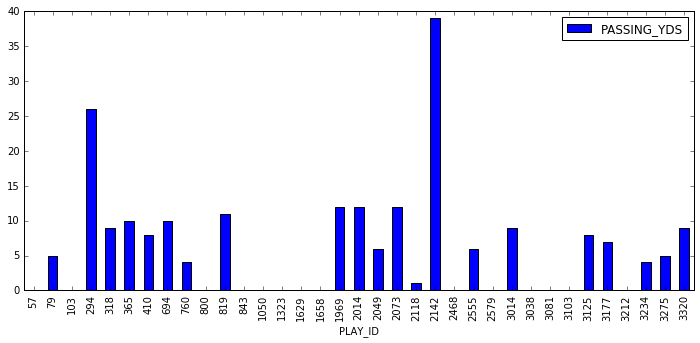

In [8]:
#example of one game for Eli Manning

query = """
select
    pp.PLAY_ID,
    PASSING_YDS
from games g

INNER JOIN drive d on
    g.GSIS_ID = d.GSIS_ID

INNER JOIN play_player pp on
    g.GSIS_ID = pp.GSIS_ID
    and pp.DRIVE_ID = d.DRIVE_ID

INNER JOIN player p on
    p.PLAYER_ID = pp.PLAYER_ID
    and g.TEAM = p.TEAM

where g.GSIS_ID = 2012090500
        and p.FULL_NAME = 'Eli Manning'
order by 
    g.GSIS_ID,
    d.DRIVE_ID,
    p.PLAYER_ID,
    pp.PLAY_ID """

plays_manning_pd = sqlContext.sql(query)
plays_manning_pd.toPandas().plot(kind='bar', x='PLAY_ID', y='PASSING_YDS', figsize=(12, 5))

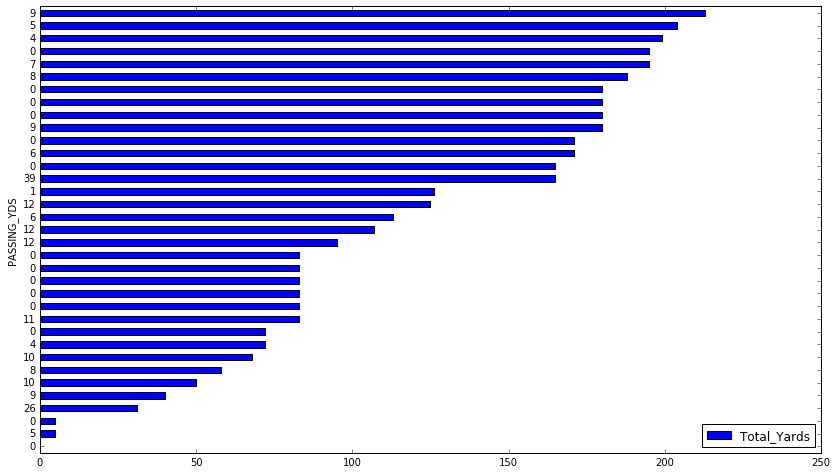

In [9]:
#Rolling sum to show the progression of the game

plays_manning_pd.registerTempTable("manning")

query = """
select
    a.PLAY_ID,
    a.PASSING_YDS,
    sum(b.PASSING_YDS) as Total_Yards
from
 manning a
inner join manning b
    on a.PLAY_ID >= b.PLAY_ID
GROUP BY
    a.PLAY_ID, a.PASSING_YDS
order by
    a.PLAY_ID
"""
pd = sqlContext.sql(query).toPandas()
pd.plot(kind='barh', stacked=True, y='Total_Yards', x="PASSING_YDS", figsize=(14, 8))

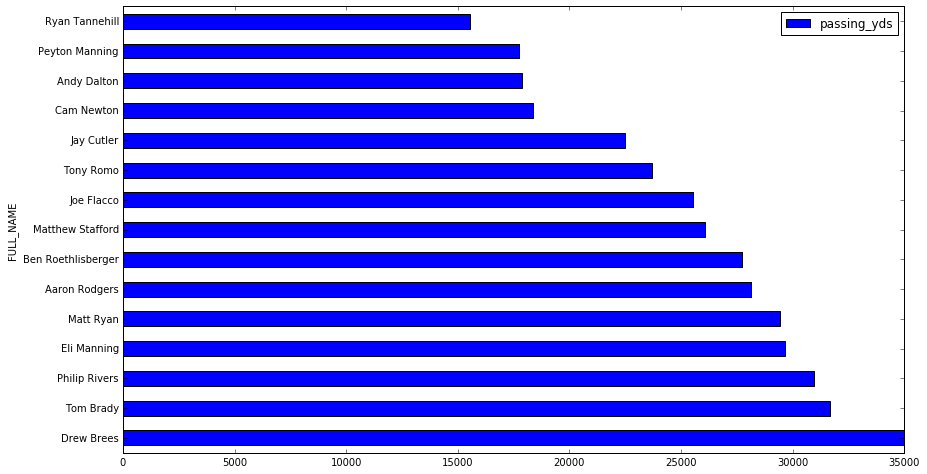

In [10]:
#Who has the most passing yards in the record set (top 15)
query = """
SELECT 
	player.FULL_NAME, 
	SUM(play_player.PASSING_YDS) AS passing_yds
FROM play_player
INNER JOIN player ON 
    player.PLAYER_ID = play_player.PLAYER_ID
INNER JOIN games ON 
    games.GSIS_ID = play_player.GSIS_ID
    and games.TEAM = player.TEAM
WHERE 
	games.season_type = 'Regular'
	AND PASSING_YDS > 0
GROUP BY player.FULL_NAME
ORDER BY SUM(play_player.PASSING_YDS) desc
limit 15
"""

pd = sqlContext.sql(query).toPandas()

pd.plot(kind='barh', stacked=True, y='passing_yds', x="FULL_NAME", figsize=(14, 8))

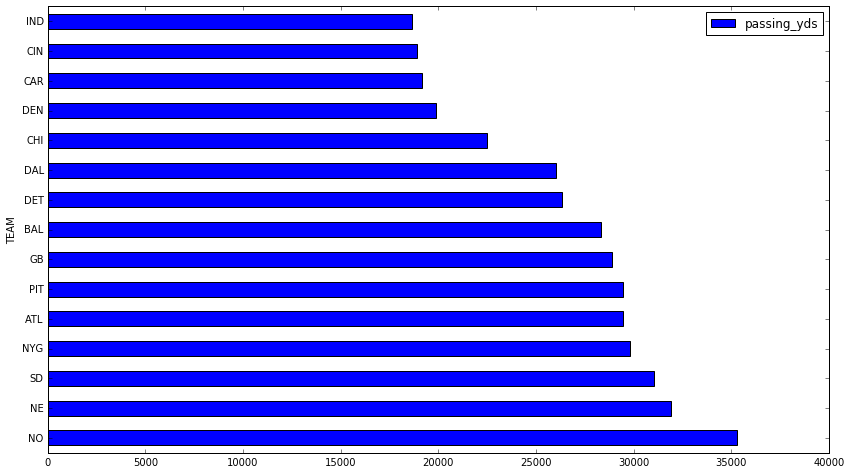

In [11]:
#what about the team with the most passing yards
query = """
SELECT 
	player.TEAM, 
	SUM(play_player.PASSING_YDS) AS passing_yds
FROM play_player
INNER JOIN player ON 
    player.PLAYER_ID = play_player.PLAYER_ID
INNER JOIN games ON 
    games.GSIS_ID = play_player.GSIS_ID
    and games.TEAM = player.TEAM
WHERE 
	games.season_type = 'Regular'
	AND PASSING_YDS > 0
GROUP BY player.TEAM
ORDER BY SUM(play_player.PASSING_YDS) desc
limit 15
"""
pd = sqlContext.sql(query).toPandas()
pd.plot(kind='barh', stacked=True, y='passing_yds', x="TEAM", figsize=(14, 8))


In [12]:
#now lets incorporate weather

In [13]:
#the weather table has a column that contains all of the JSON returned for each day\locaton queried 
#in most cases we are only interested in some basic observations, so the first step is to pull those out

#We can build a function to pull out the value that we want and return the metric

#here is an example of the data we are working with:

example_data = distinct_games_weather_df.take(1)

for rrow in example_data:
    #let's just pick the 12th value assuming that roughly the middle of the day is sufficienct
    #for the analysis
    print rrow.weather["observations"][12]
    
    #or to see a specific value
    print rrow.weather["observations"][12]["temp"]


{u'terse_phrase': None, u'expire_time_gmt': 1441306380, u'vis': 9, u'wx_icon': 28, u'min_temp': None, u'uv_index': 5, u'precip_hrly': 0, u'uv_desc': None, u'obs_id': None, u'pressure_desc': None, u'heat_index': 85, u'wspd': 5, u'rh': 54, u'qualifier_svrty': None, u'valid_time_gmt': 1441299180, u'wc': 83, u'qualifier': None, u'blunt_phrase': None, u'wdir': None, u'icon_extd': 2800, u'obs_name': None, u'dewPt': 65, u'pressure': None, u'precip_total': None, u'key': None, u'class': None, u'pressure_tend': None, u'temp': 83, u'gust': None, u'wdir_cardinal': None, u'snow_hrly': None, u'day_ind': None, u'feels_like': 85, u'wx_phrase': None, u'max_temp': None}
83


In [14]:
#now create a function that takes the JSON blob and returns a value
import types

def get_w_metric(metric, datablob):
    i = 10
    try:
        for obs in datablob["observations"][11:20]:
            if obs[metric]: 
                #return obs[metric]
                return str(obs[metric])
    except:
        return 'na'

sqlContext.registerFunction("get_w_metric", get_w_metric)

In [15]:
#test the function

query = "select *, get_w_metric('temp', weather) as temp from weather  limit 10"
sqlContext.sql(query).show()

+----------+--------+--------------------+--------+--------+---------+--------------+--------------------+----+
|   GSIS_ID|LOCATION|          START_TIME| datekey|latitude|longitude|  stadium_city|             weather|temp|
+----------+--------+--------------------+--------+--------+---------+--------------+--------------------+----+
|2015090358|     PIT|2015-09-03 16:30:...|20150903|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  79|
|2015092009|     PIT|2015-09-20 10:00:...|20150920|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  62|
|2009082953|     PIT|2009-08-29 16:30:...|20090829|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  67|
|2009081350|     PIT|2009-08-13 17:00:...|20090813|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  64|
|2009102504|     PIT|2009-10-25 10:00:...|20091025|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  46|
|2009091000|     PIT|2009-09-10 17:30:...|20090910|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n..

In [16]:
#create a dataframe with weather metrics
query = """ select 
                *, 
                get_w_metric('temp', weather) as temp,
                get_w_metric('vis', weather) as vis,
                get_w_metric('precip_hrly', weather) as precip_hrly,
                get_w_metric('heat_index', weather) as heat_index,
                get_w_metric('wspd', weather) as wspd,
                get_w_metric('precip_total', weather) as precip_total,
                get_w_metric('pressure', weather) as pressure
        from weather """
distinct_games_weather_df_wmetrics = sqlContext.sql(query)
distinct_games_weather_df_wmetrics.registerTempTable("weather_metrics")

In [17]:
distinct_games_weather_df_wmetrics.show(5)

+----------+--------+--------------------+--------+--------+---------+--------------+--------------------+----+---+-----------+----------+----+------------+--------+
|   GSIS_ID|LOCATION|          START_TIME| datekey|latitude|longitude|  stadium_city|             weather|temp|vis|precip_hrly|heat_index|wspd|precip_total|pressure|
+----------+--------+--------------------+--------+--------+---------+--------------+--------------------+----+---+-----------+----------+----+------------+--------+
|2015090358|     PIT|2015-09-03 16:30:...|20150903|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  79|  9|       null|        81|   5|        null|    null|
|2015092009|     PIT|2015-09-20 10:00:...|20150920|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  62| 10|       null|        62|   9|        null|    null|
|2009082953|     PIT|2009-08-29 16:30:...|20090829|  40.447|  -80.016|Pittsburgh, PA|Map(metadata -> n...|  67|  9|       null|        67|   9|        null|    null|
|200

In [18]:
query = """

select 
    *
from
    games g
inner join weather_metrics w on
    g.GSIS_ID = w.GSIS_ID
limit 5
"""
sqlContext.sql(query).toPandas()

,GSIS_ID,GAMEKEY,START_TIME,WEEK,DAY_OF_WEEK,SEASON_YEAR,SEASON_TYPE,FINISHED,LOCATION,HOME_GAME,...,longitude,stadium_city,weather,temp,vis,precip_hrly,heat_index,wspd,precip_total,pressure
0,2012080954,55765,2012-08-09 16:30:00,1,Thursday,2012,Preseason,t,PHI,1,...,-75.168,"Philadelphia, PA","{u'observations': [{u'terse_phrase': None, u'e...",73,4,None,73,5,None,None
1,2012080955,55761,2012-08-09 17:00:00,1,Thursday,2012,Preseason,t,SD,1,...,-117.11,"San Diego, CA","{u'observations': [{u'terse_phrase': None, u'e...",67,3,None,67,6,None,None
2,2012080956,55766,2012-08-09 17:30:00,1,Thursday,2012,Preseason,t,CHI,1,...,-87.617,"Chicago, IL","{u'observations': [{u'terse_phrase': None, u'e...",76,10,None,76,5,None,None
3,2012081051,55768,2012-08-10 16:30:00,1,Friday,2012,Preseason,t,CIN,1,...,-84.516,"Cincinnati, OH","{u'observations': [{u'terse_phrase': None, u'e...",68,7,None,68,3,None,None
4,2012081052,55769,2012-08-10 16:30:00,1,Friday,2012,Preseason,t,DET,1,...,-83.046,"Detroit, MI","{u'observations': [{u'terse_phrase': None, u'e...",63,8,None,63,2,None,None


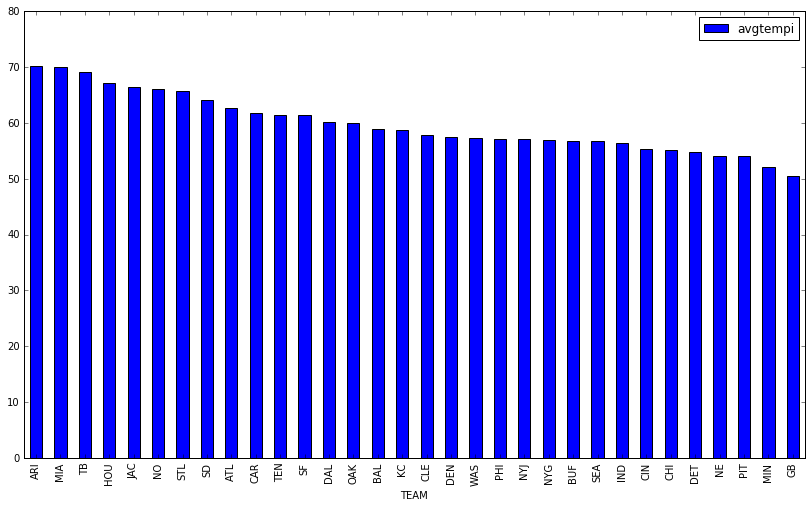

In [19]:
query = """

select 
    g.TEAM,
    avg(w.temp) as avgtempi
from
    games g
inner join weather_metrics w on
    g.GSIS_ID = w.GSIS_ID
group by g.TEAM
order by avgtempi desc

"""
pd = sqlContext.sql(query).toPandas()
pd.plot(kind="bar", x="TEAM", y="avgtempi", figsize=(14, 8));

In [20]:
query = """SELECT
    games.GSIS_ID,
	player.TEAM,
	player.FULL_NAME,
	player.PROFILE_ID,
	sum(play_player.PASSING_YDS) AS passing_yds,
	avg(w.temp) as temp
FROM play_player
INNER JOIN player ON 
    player.PLAYER_ID = play_player.PLAYER_ID
INNER JOIN games ON 
    games.GSIS_ID = play_player.GSIS_ID
    and games.TEAM = player.TEAM
INNER JOIN weather_metrics w ON
    w.GSIS_ID = games.GSIS_ID
WHERE 
	games.SEASON_TYPE = 'Regular'
	AND PASSING_YDS > 0
    AND w.temp is not null
GROUP BY FULL_NAME, PROFILE_ID, player.TEAM, games.GSIS_ID
ORDER BY FULL_NAME, PROFILE_ID
"""

players_yards = sqlContext.sql(query)
players_yards.registerTempTable("players_yards")

In [21]:
#test out a simple correlation Aaron Rodgers, Passing Yards to Temp
query = """
select
    passing_yds,
    temp
from
    players_yards
where FULL_NAME = 'Aaron Rodgers'
"""
yds_temp_df = sqlContext.sql(query)

In [22]:
#build list of players to loop through
query = """
select
    FULL_NAME,
    count(*) as games,
    corr(passing_yds, temp) as corr
from
    players_yards
group by FULL_NAME

"""

sqlContext.sql(query).registerTempTable("temp_yds_corr")


In [25]:
query = "select * from temp_yds_corr where abs(corr) > 0 order by corr"
players_pd = sqlContext.sql(query).toPandas()

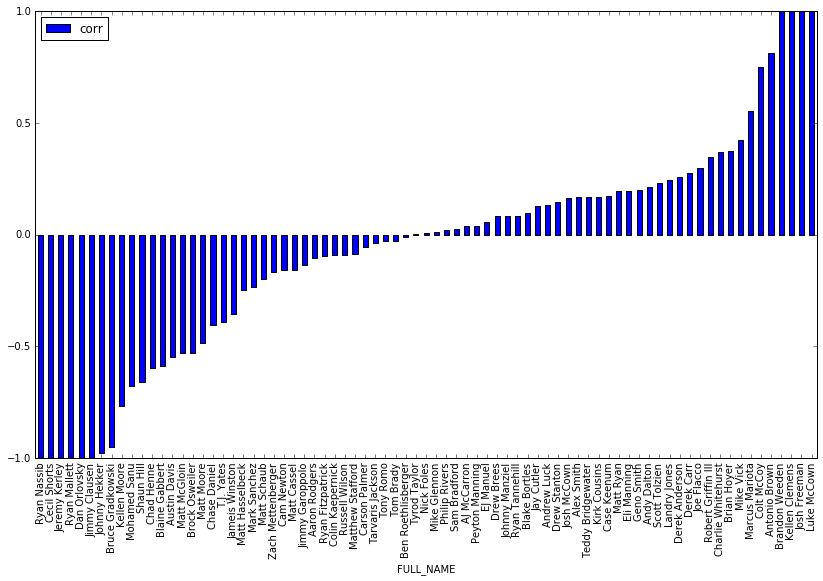

In [26]:
players_pd.plot(kind="bar", x="FULL_NAME", y="corr", figsize=(14, 8));

In [27]:
query = "select * from temp_yds_corr where abs(corr) > CAST('.5' AS FLOAT)"
players_pd = sqlContext.sql(query).toPandas()
players_pd

,FULL_NAME,games,corr
0,Austin Davis,3,-0.549408
1,Ryan Nassib,2,-1.000000
2,Mohamed Sanu,5,-0.680293
3,Matt McGloin,9,-0.529300
4,Chad Henne,28,-0.597849
5,Colt McCoy,6,0.752440
6,Brock Osweiler,13,-0.528733
7,Ryan Mallett,2,-1.000000
8,Cecil Shorts,2,-1.000000
9,Kellen Moore,3,-0.766237


<img src="https://lintvkhon.files.wordpress.com/2015/07/marcus-mariota-sandy-beach-interview.jpg?w=400"></img>

In [28]:
query = """
select
    *
from
    players_yards
where 
    FULL_NAME = 'Marcus Mariota' 
order by temp
"""
players_pd = sqlContext.sql(query).toPandas()
players_pd

,GSIS_ID,TEAM,FULL_NAME,PROFILE_ID,passing_yds,temp
0,2015122005,TEN,Marcus Mariota,2552466,32,41
1,2015101806,TEN,Marcus Mariota,2552466,231,58
2,2015111503,TEN,Marcus Mariota,2552466,185,58
3,2015120604,TEN,Marcus Mariota,2552466,268,59
4,2015112907,TEN,Marcus Mariota,2552466,218,59
5,2015110803,TEN,Marcus Mariota,2552466,371,65
6,2015121301,TEN,Marcus Mariota,2552466,274,66
7,2015092003,TEN,Marcus Mariota,2552466,262,67
8,2015101106,TEN,Marcus Mariota,2552466,189,68
9,2015092709,TEN,Marcus Mariota,2552466,367,68


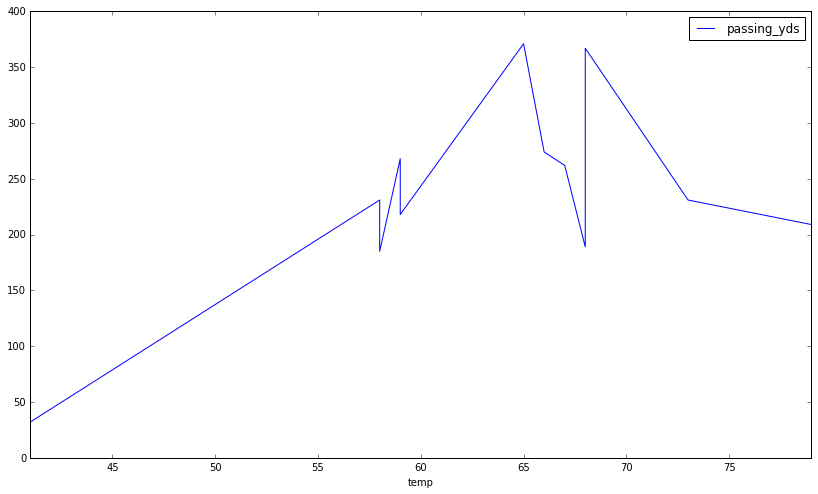

In [65]:
players_pd.plot(kind="line", x="temp", y="passing_yds", figsize=(14, 8));


                            OLS Regression Results                            
Dep. Variable:            passing_yds   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     4.427
Date:                Fri, 03 Jun 2016   Prob (F-statistic):             0.0617
Time:                        13:18:17   Log-Likelihood:                -68.095
No. Observations:                  12   AIC:                             140.2
Df Residuals:                      10   BIC:                             141.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -89.6393    156.565     -0.573      0.5

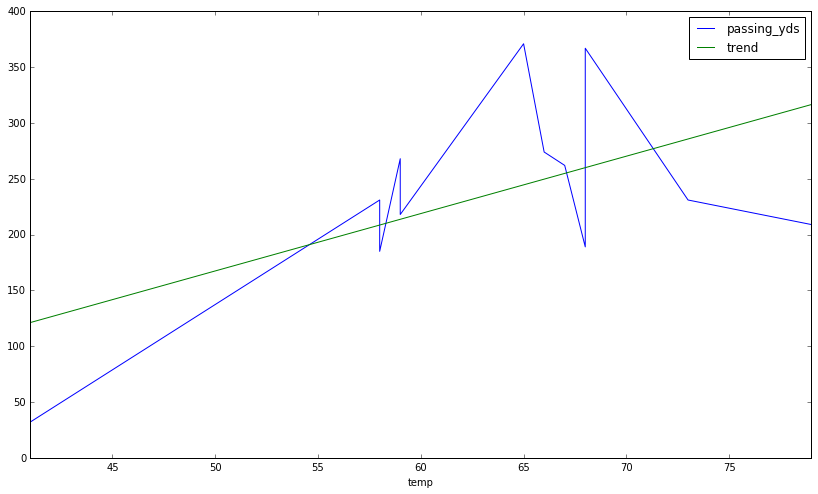

In [81]:
from matplotlib import pyplot
import statsmodels.api as sm

fig, ax = pyplot.subplots()
players_pd.plot(x='temp', y='passing_yds', ax=ax, figsize=(14, 8))
model = sm.formula.ols(formula='passing_yds ~ temp', data=players_pd)
res = model.fit()
players_pd.assign(trend=res.fittedvalues).plot(x='temp', y='trend', ax=ax)

print res.summary()